In [20]:
import sys
print(sys.version)
import os
import re
import glob
import datetime as dt

import numpy as np
np.set_printoptions(precision=5, linewidth=120, suppress=True)
import pandas as pd
pd.set_option('display.max_rows', None)
import statsmodels.api as sm
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
print('matplotlib: {}'.format(matplotlib.__version__))
from matplotlib.colors import LinearSegmentedColormap

from mosek.fusion import *

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]
matplotlib: 3.3.4


{'CodeCell': {'cm_config': {'autoCloseBrackets': False}}}

In [ ]:
# Data downloading:
# If the user has an API key for alphavantage.co, then this code part will download the data. 
# The code can be modified to download from other sources. To be able to run the examples, 
# and reproduce results in the cookbook, the files have to have the following format and content:
# - File name pattern: "daily_adjusted_[TICKER].csv", where TICKER is the symbol of a stock. 
# - The file contains at least columns "timestamp", "adjusted_close", and "volume".
# - The data is daily price/volume, covering at least the period from 2016-03-18 until 2021-03-18, 
# - Files are for the stocks PM, LMT, MCD, MMM, AAPL, MSFT, TXN, CSCO.
alphaToken = None
 
if alphaToken is not None:
    import requests
    import time
    
    list_tickers = ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]
    
    for ticker in list_tickers:
        url = rf"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={ticker}&apikey={alphaToken}&outputsize=full&datatype=csv"
        result = requests.get(url, allow_redirects=True)
        fname = f"daily_adjusted_{ticker}.csv"
        folder = "stock_data"
        if not os.path.isdir(folder):
            os.mkdir(folder)
        open(os.path.join(folder, fname), "wb").write(result.content)
        print(f"Downloaded {fname}.")
        # Limit is 5 downloads per minute.
        time.sleep(12)   

In [21]:
class DataReader:
    def __init__(self, folder_path, exclude=None):
        self.folder_path = folder_path
        self.name_format = r"daily_adjusted_*.csv"
        self.exclude = exclude if exclude is not None else []
        self.df_prices = None

    def read_data(self):
        # Get list of files from path, named as name_format 
        list_files = glob.glob(os.path.join(self.folder_path, self.name_format))
        file_names = "\n".join(list_files)
        print("Found data files: \n{}\n".format(file_names))

        # Exclude specified files
        for symbol in self.exclude:
            fname = os.path.join(self.folder_path, self.name_format.replace("*", symbol))
            if fname in list_files:
                list_files.remove(fname)
        
        # Collect data from the files into a Dataframe
        dict_prices = {}
        for file_name in list_files: 
            m = re.search(self.name_format.replace("*", "(.+)"), file_name)
            
            # Get symbol name
            symbol = m.group(1)
        
            # Read data file
            df_data = pd.read_csv(file_name)

            # Set timestamp as index 
            df_data['timestamp'] = pd.to_datetime(df_data['timestamp'])
            df_data = df_data.set_index('timestamp')
            df_data.index.name = "date"

            # Obtain adjusted close price data 
            dict_prices[symbol] = df_data['adjusted_close']

        self.df_prices = pd.concat(dict_prices.values(), axis=1, keys=dict_prices.keys()).sort_index()
        
    def get_period(self, start_date, end_date):              
        start_idx = self.df_prices.index.get_loc(pd.to_datetime(start_date), method='nearest')
        end_idx = self.df_prices.index.get_loc(pd.to_datetime(end_date), method='nearest')
        df_prices = self.df_prices.iloc[start_idx:(end_idx + 1)]
        
        return df_prices

In [22]:
# We load daily stock price data from CSV files. The data is adjusted for splits and dividends. 
# The files are in "stock_data" folder, named as "daily_adjusted_[TICKER].csv"
dr = DataReader(folder_path="stock_data", exclude=["SPY"])
dr.read_data()
df_prices = dr.get_period(start_date="2016-03-18", end_date="2021-03-18")
columns = ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]
df_prices = df_prices[columns]

Found data files: 
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_CSCO.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_SPY.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_LMT.csv



In [23]:
# Create benchmark
df_prices['bm'] = df_prices.iloc[:-2, 0:8].mean(axis=1)

In [24]:
# Convert daily prices to weekly prices
df_weekly_prices = df_prices.resample('W').last()

In [25]:
# Compute weekly logarithmic returns
df_weekly_log_returns = np.log(df_weekly_prices) - np.log(df_weekly_prices.shift(1))
df_weekly_log_returns = df_weekly_log_returns.dropna(how='all')
df_weekly_log_returns = df_weekly_log_returns.fillna(0)

array([[<AxesSubplot:title={'center':'PM'}>, <AxesSubplot:title={'center':'LMT'}>,
        <AxesSubplot:title={'center':'MCD'}>],
       [<AxesSubplot:title={'center':'MMM'}>, <AxesSubplot:title={'center':'AAPL'}>,
        <AxesSubplot:title={'center':'MSFT'}>],
       [<AxesSubplot:title={'center':'TXN'}>, <AxesSubplot:title={'center':'CSCO'}>,
        <AxesSubplot:title={'center':'bm'}>]], dtype=object)

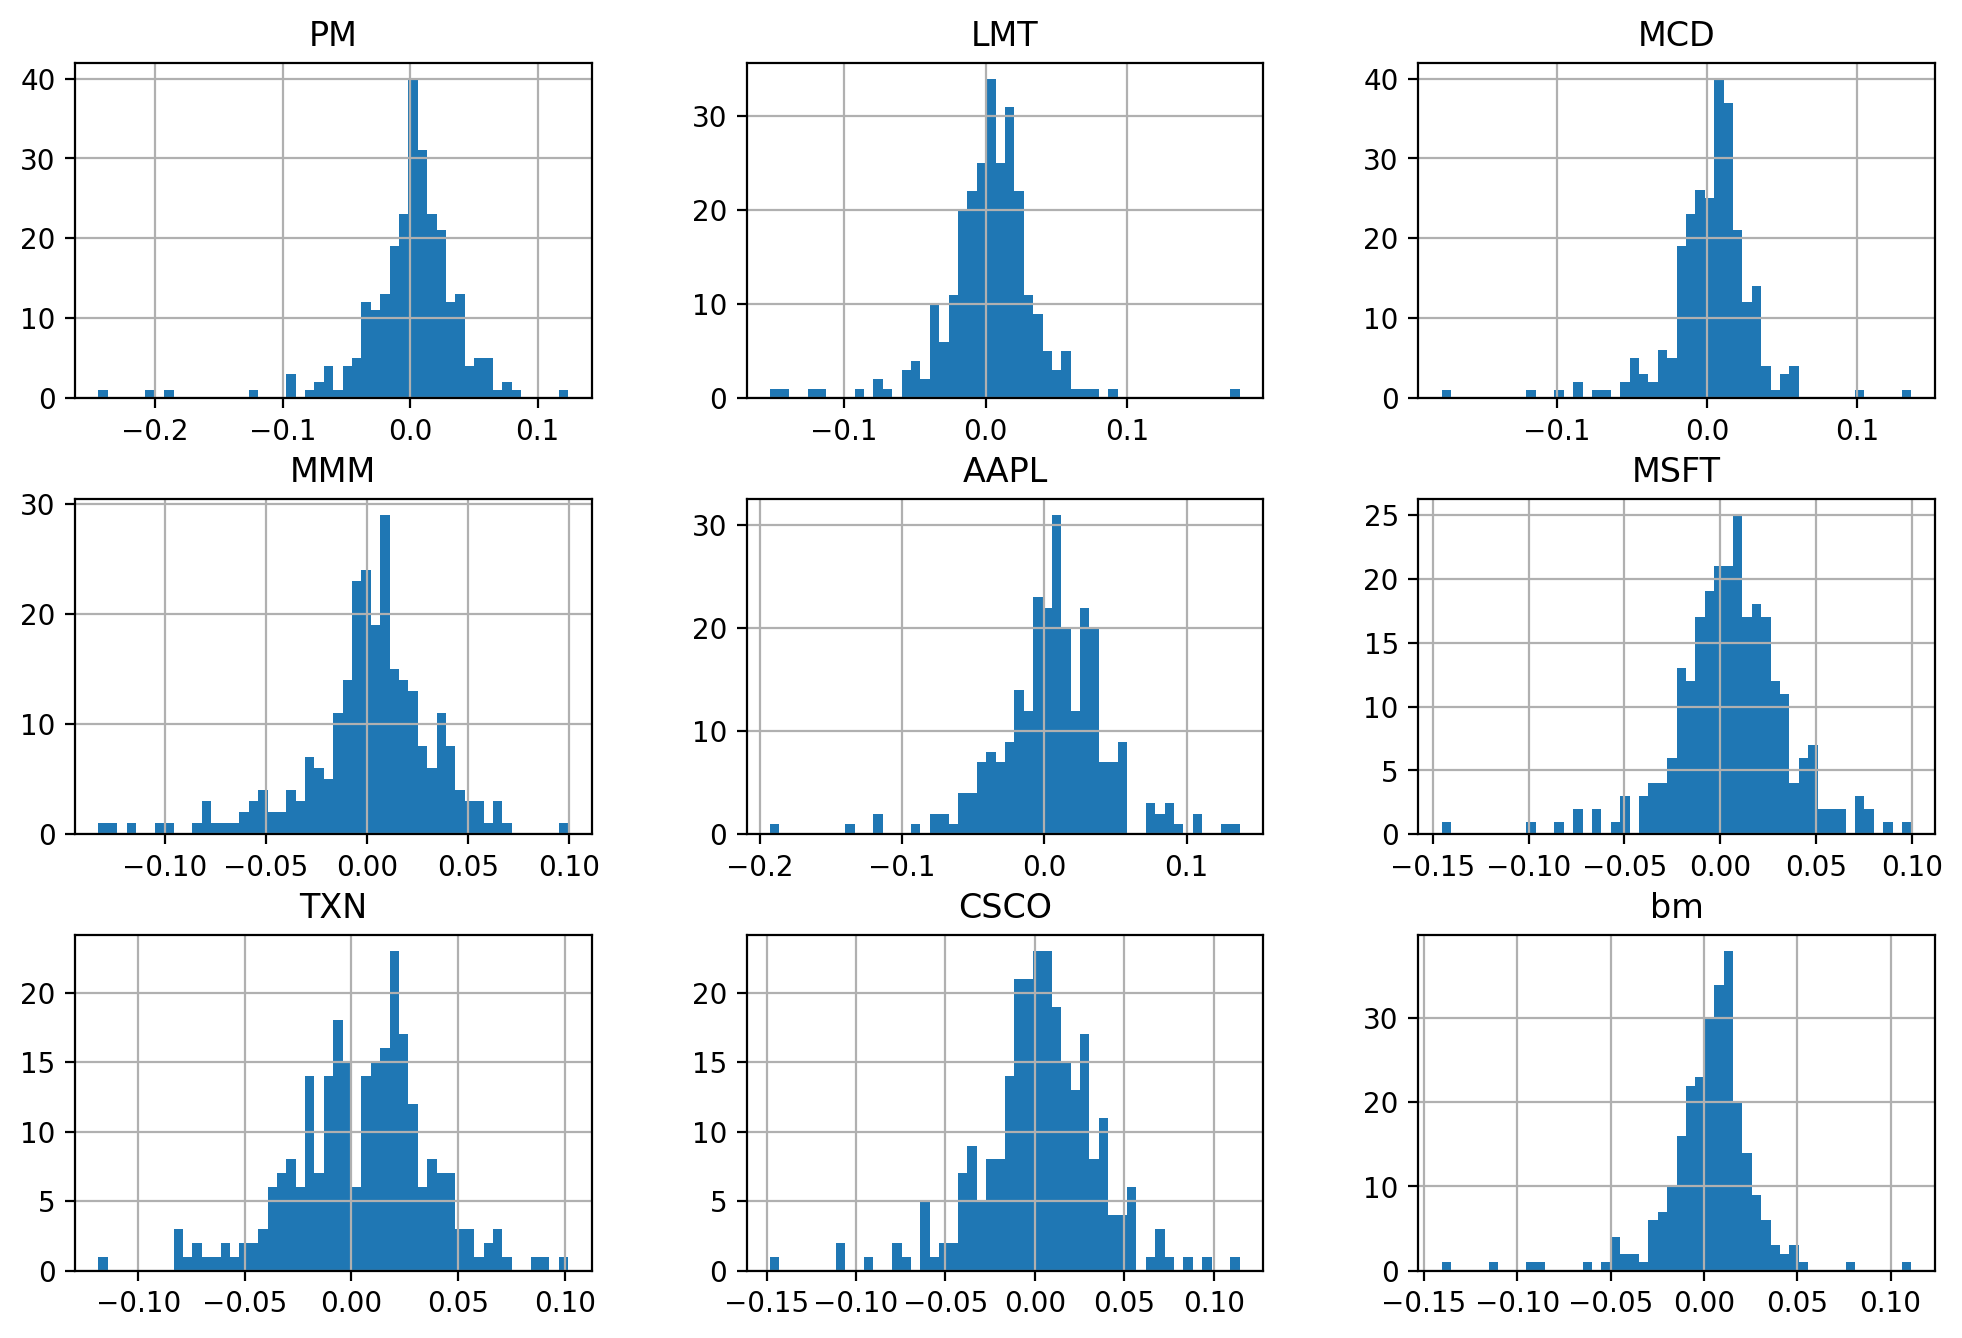

In [26]:
# Show histograms of weekly logarithmic returns
df_weekly_log_returns.hist(bins=50)

In [27]:
# Compute mean and covariance of weekly logarithmic returns
return_array = df_weekly_log_returns.to_numpy()
T = return_array.shape[0]
m_weekly_log = np.mean(return_array, axis=0)
S_weekly_log = np.cov(return_array.transpose())

In [28]:
# Convert weekly logarithmic return statistics to yearly linear return statistics
def get_lin_parameters(m_weekly_log, S_weekly_log):              
    # Project logarithmic return statistics to investment horizon
    m_log = 52 * m_weekly_log
    S_log = 52 * S_weekly_log
    
    # Pricing
    p_0 = df_weekly_prices.iloc[0].to_numpy()
    m_P = p_0 * np.exp(m_log + 1/2*np.diag(S_log))
    S_P = np.outer(m_P, m_P) * (np.exp(S_log) - 1)
    
    # Linear return statistics on the investment horizon
    m = 1 / p_0 * m_P - 1
    S = 1 / np.outer(p_0, p_0) * S_P
    
    # Remove data corresponding to the benchmark
    m = m[:-1]
    S = S[:-1, :-1]

    return m, S

In [29]:
# Factor model for active returns 
def factor_model(m_weekly_log, S_weekly_log):
    # Project logarithmic return statistics to investment horizon
    m_log = 52 * m_weekly_log
    S_log = 52 * S_weekly_log
    
    # Generate logarithmic return scenarios
    scenarios_log = np.random.default_rng().multivariate_normal(m_log, S_log, 100000)
    
    # Convert logarithmic return scenarios to linear return scenarios 
    scenarios_lin = np.exp(scenarios_log) - 1
    
    # Do linear regression 
    params = []
    resid = []
    X = np.zeros((scenarios_lin.shape[0], 2))
    X[:, 0] = scenarios_lin[:, -1]
    X[:, 1] = 1
    for k in range(N):
        y = scenarios_lin[:, k]
        model = sm.OLS(y, X, hasconst=True).fit()
        resid.append(model.resid)
        params.append(model.params)
    resid = np.array(resid)
    params = np.array(params)
    
    # Get parameter estimates
    a = params[:, 1]
    B = params[:, 0]
    s_M = np.var(X[:, 0])
    S_theta = np.cov(resid)
    S_theta = np.diag(np.diag(S_theta))
    
    return a, B

In [30]:
def EfficientFrontier(N, a, B, G, xbm, deltas, uh, ub, lh, lb):

    with Model("Case study") as M:
        # Settings
        #M.setLogHandler(sys.stdout)
        
        # Variables 
        # The variable x is the fraction of holdings in each security. 
        # It is restricted to be positive, which imposes the constraint of no short-selling.   
        x = M.variable("x", N, Domain.greaterThan(0.0))
        
        # Active holdings
        xa = Expr.sub(x, xbm) 
        
        # The variable s models the portfolio variance term in the objective.
        s = M.variable("s", 1, Domain.unbounded())
    
        # Budget constraint
        M.constraint('budget_x', Expr.sum(x), Domain.equalsTo(1))
        
        # Constraint on active holdings
        M.constraint('ubound-h', Expr.sub(uh, xa), Domain.greaterThan(0.0))
        M.constraint('lbound-h', Expr.sub(xa, lh), Domain.greaterThan(0.0))
        
        # Constraint on portfolio active beta 
        port_act_beta = Expr.sub(Expr.dot(B, x), 1)
        M.constraint('ubound-b', Expr.sub(ub, port_act_beta), Domain.greaterThan(0.0))
        M.constraint('lbound-b', Expr.sub(port_act_beta, lb), Domain.greaterThan(0.0))
        
        # Conic constraint for the portfolio variance
        M.constraint('risk', Expr.vstack(s, 1, Expr.mul(G.T, xa)), Domain.inRotatedQCone())
        
        # Objective (quadratic utility version)
        delta = M.parameter()
        M.objective('obj', ObjectiveSense.Maximize, Expr.sub(Expr.dot(a, x), Expr.mul(delta, s)))
    
        # Create DataFrame to store the results. Last security name (the SPY ETF) is removed.
        columns = ["delta", "obj", "return", "risk"] + df_prices.columns[:-1].tolist()
        df_result = pd.DataFrame(columns=columns)
        for d in deltas:
            # Update parameter
            delta.setValue(d);
            
            # Solve optimization
            M.solve()
            
            # Save results
            portfolio_return = a @ x.level()
            portfolio_risk = np.sqrt(2 * s.level()[0])
            row = pd.Series([d, M.primalObjValue(), portfolio_return, portfolio_risk] + list(x.level()), index=columns)
            df_result = df_result.append(row, ignore_index=True)

        return df_result

In [31]:
# Number of securities (We subtract one to account for SPY)
N = df_prices.shape[1] - 1  

# Get optimization parameters
m, S = get_lin_parameters(m_weekly_log, S_weekly_log)
a, B = factor_model(m_weekly_log, S_weekly_log)

# Cholesky factor of S to use in conic risk constraint
G = np.linalg.cholesky(S)  

In [32]:
# Parameters
xbm = np.ones(N) / N
uh = np.ones(N) * 0.5
lh = -np.ones(N) * 0.5
ub = 0.5
lb = -0.5

deltas = np.logspace(start=-0.5, stop=2, num=20)[::-1]

df_result = EfficientFrontier(N, a, B, G, xbm, deltas, uh, ub, lh, lb)
mask = df_result < 0
mask.iloc[:, :2] = False
df_result[mask] = 0
df_result

,delta,obj,return,risk,PM,LMT,MCD,MMM,AAPL,MSFT,TXN,CSCO
0,100.000000,0.052791,0.059281,0.011393,1.079292e-01,1.161211e-01,1.288408e-01,1.001286e-01,0.131593,0.153074,1.388295e-01,1.234831e-01
1,73.861998,0.055088,0.063875,0.015425,1.018882e-01,1.129790e-01,1.301999e-01,9.132711e-02,0.133927,0.163009,1.437234e-01,1.229464e-01
2,54.555948,0.058197,0.070094,0.020883,9.370956e-02,1.087250e-01,1.320400e-01,7.941124e-02,0.137086,0.176460,1.503491e-01,1.222198e-01
3,40.296113,0.062407,0.078514,0.028274,8.263606e-02,1.029653e-01,1.345310e-01,6.327755e-02,0.141362,0.194671,1.593202e-01,1.212366e-01
4,29.763514,0.068107,0.089913,0.038280,6.764411e-02,9.516731e-02,1.379036e-01,4.143362e-02,0.147152,0.219327,1.714661e-01,1.199059e-01
5,21.983926,0.075823,0.105346,0.051825,4.734910e-02,8.461201e-02,1.424715e-01,1.186291e-02,0.154992,0.252703,1.879078e-01,1.181011e-01
6,16.237767,0.086029,0.123613,0.068039,1.612908e-02,6.554650e-02,1.408475e-01,1.772865e-08,0.166271,0.298725,2.032193e-01,1.092615e-01
7,11.993539,0.098571,0.143036,0.086109,1.966497e-08,2.999650e-02,1.236844e-01,8.199399e-09,0.177217,0.360607,2.203946e-01,8.810084e-02
8,8.858668,0.113124,0.164284,0.107472,3.102592e-09,3.456691e-08,7.924395e-02,2.690715e-09,0.188801,0.441501,2.414877e-01,4.896678e-02
9,6.543189,0.129726,0.186773,0.132049,3.039709e-09,7.957019e-09,8.153139e-08,2.544319e-09,0.204418,0.537746,2.578356e-01,1.115127e-08


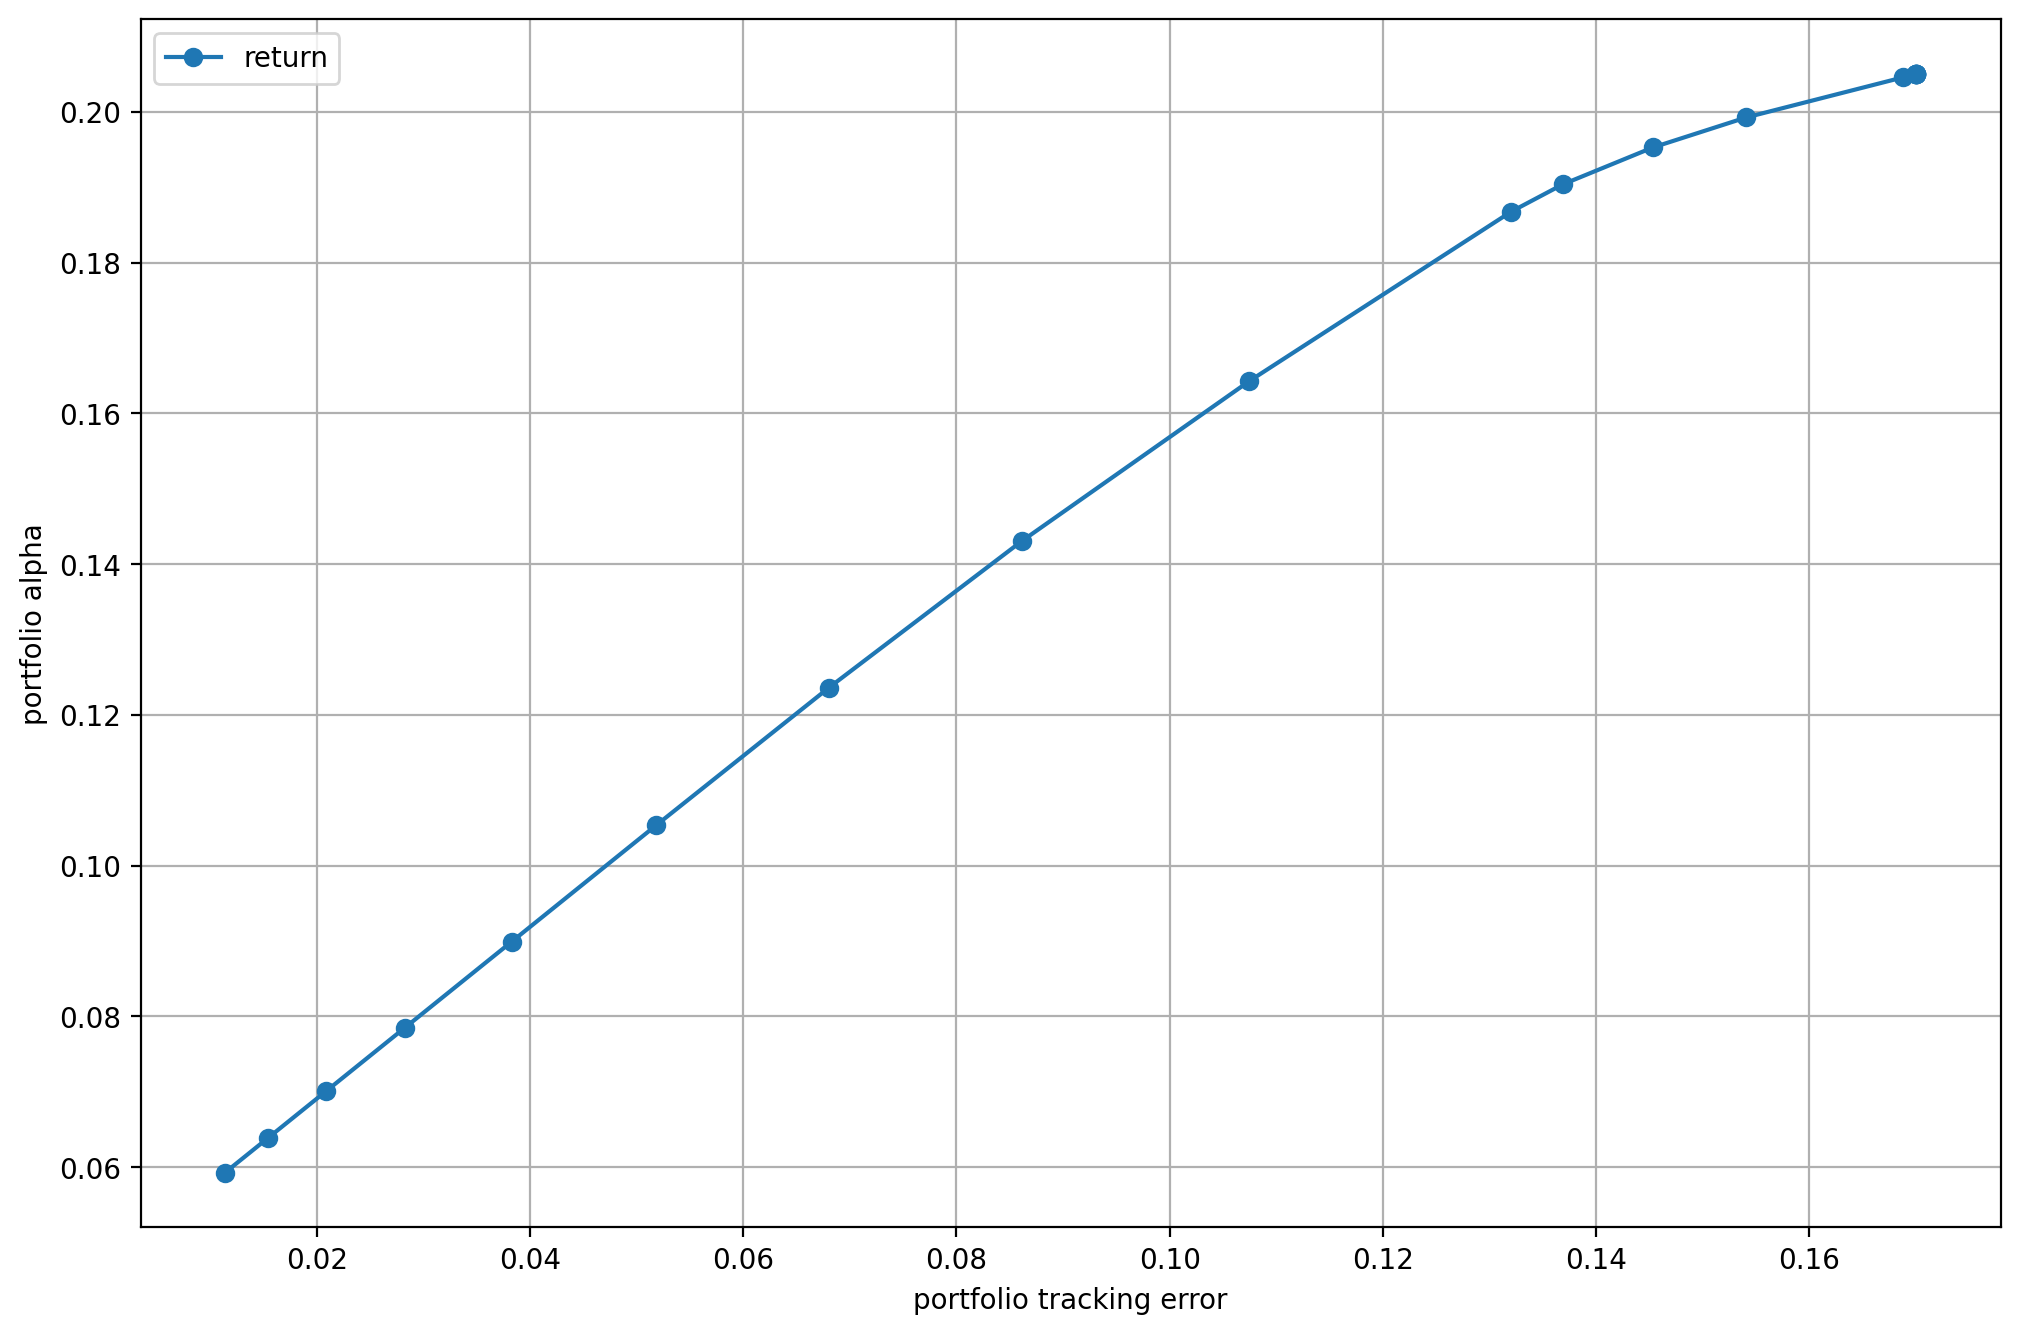

In [33]:
# Efficient frontier
ax = df_result.plot(x="risk", y="return", style="-o", xlabel="portfolio tracking error", ylabel="portfolio alpha", grid=True)

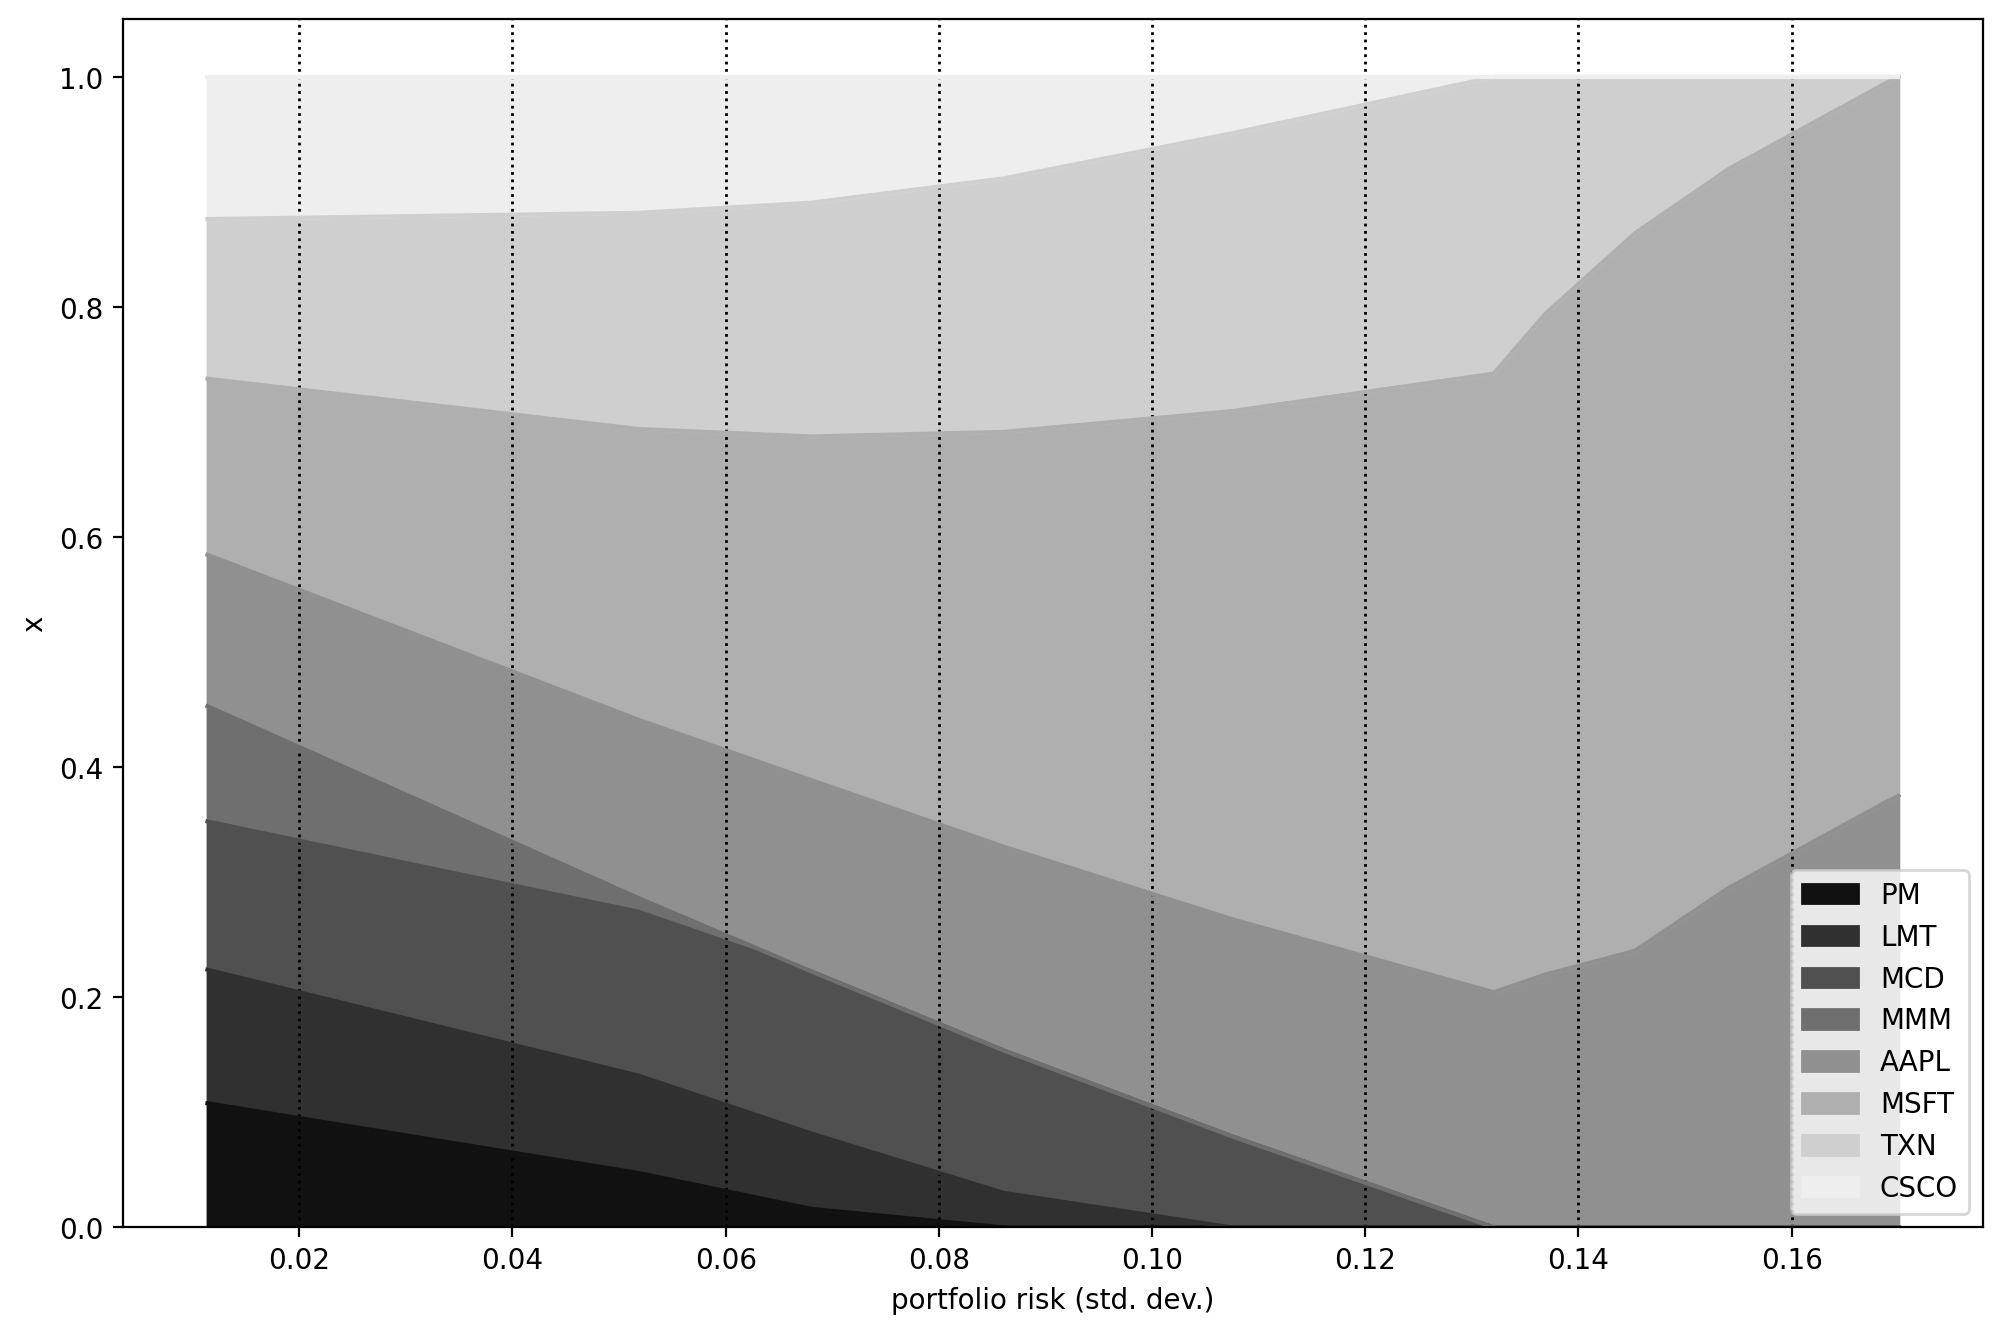

In [34]:
my_cmap = LinearSegmentedColormap.from_list("non-extreme gray", ["#111111", "#eeeeee"], N=256, gamma=1.0)
ax1 = df_result.set_index('risk').iloc[:, 3:].plot.area(logx=False, colormap=my_cmap, 
                                                        xlabel='portfolio risk (std. dev.)', ylabel="x")
ax1.grid(which='both', axis='x', linestyle=':', color='k', linewidth=1)